<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S44_logistics_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import plotly.express as px
import plotly.graph_objects as go
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook import logistics
from gtbook.display import show

# Localization

> We introduce three instances of Bayes filtering: Kalman filters, Markov localization, and Monte Carlo localization.

**This Section is still in draft mode and was released for adventurous spirits (and TAs) only.**

In [3]:
from gtbook.display import randomImages
from IPython.display import display
display(randomImages(4, 4, "steampunk", 1))

The first order of business is creating a small ground truth trajectory. Rather than using simulation we generate it deterministically here, so ew can easily assess the quality of our solution. In particular, let us start at and move to the right, then up between the middle two shelves:

In [4]:
left = [(10+i*5,6) for i in range(9)]
up = [(50,6+i*5) for i in range(1,6)]
N = len(left) + len(up)
indices = range(1, N+1)
x = {k:gtsam.symbol('x',k) for k in indices}
values = gtsam.VectorValues()
for i, state in enumerate(left+up): values.insert(x[i+1], state)
values

Variable,value
x1,10 6
x2,15 6
x3,20 6
x4,25 6
x5,30 6
x6,35 6
x7,40 6
x8,45 6
x9,50 6
x10,50 11


Note above we used a `gtsam.VectorValues` to store the ground truth trajectory, which will come in handy again when we simulate the measurements. Below we show this "ground truth" trajectory overlaid on the warehouse map we introduced before:

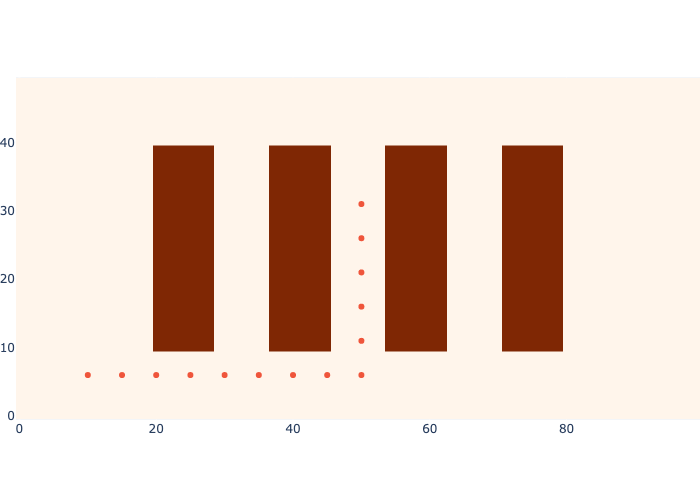

In [5]:
ground_truth = np.array([values.at(x[k]) for k in indices])
logistics.show_map(logistics.base_map, ground_truth)

## Markov Localization

> Complicated sensors necessitate expressive density representations.

Through finite element discretization we can use the sum-product algorithm from the previous chapter, as is. When applied to robot localization, as we are using a discrete Markov chain representation, this approach has been called **Markov Localization**. However, because of the computational expense involved, we will not be able to run the sum-product algorithm over *multiple* times steps. Instead of asking for the full posterior over an entire sequence, we will have to be content with the posterior on the *current state* only. This approach is called *filtering*, and this is where we start below.

### The Bayes Filter

> The Bayes filter is a recursive, ons-step sum-product algorithm.

The **Bayes filter** is a simple inference scheme that recursively implements the sum-product algorithm.
In this case we present the discrete version, which will yield Markov localization.
However,  the same general scheme underlies the venerable Kalman filter, and Monte Carlo Localization, which is based on a sampling-based density representation.

We assume a finite element discretization such that a density $p(x_k)$ over continuous states $x_k$ is approximated by a discrete probability distribution $P(X_k)$. The only difference from the previous chapter, where we discussed discreet state spaces, is that in a finite element discretization the cardinality of the discrete states is typically much larger. Recall from section 4.1 that for our $100m \times 50m$ warehouse example, even at a relatively course resolution of 1m by 1 m cells, our state space had a cardinality of 5000 finite elements. That is exactly what makes reasoning over multiple time steps computationally challenging. In other words, we have to give up on computing the joint posterior $P(X_1, X_2, ...X_k)$.

Instead, in the Bayes filter we are only interested in estimating the state of the
robot at the *current time* $t$, given all the measurements up to and
including time $t$. 
In Bayesian fashion, we attempt at characterizing our complete knowledge of the state $X_k$ by computing its posterior $P(X_k)$, which is also called the **filtering distribution**.
To be very clear, we indicate exactly what information we are
conditioning on when giving the formulas for the Bayes filter. To that
end, we introduce the notation
$\mathcal{Z}^{k}=\{z_{1},z_{2},\ldots z_{k}\}$, i.e., all measurements
$o$ up to and including time $t$. 
Similarly, we define the controls
$\mathcal{U}^{k}=\{u_{1},u_{2},\ldots u_{k-1}\}$. 
Note there is always one less control variable than there are measurements, and we start off the algorithm with Bayes rule as applied to $k=1$:

$$
P(X_1|\mathcal{Z}^1=\{z_1\}, \mathcal{U}^1=\{\}) \propto L(X_1;z_1)P(X_1)
$$

Given this, recursively assuming that we have a probability distribution
$P(x_{t-1}|\mathcal{Z}^{k-1},\mathcal{U}^{k-1})$ over the previous state $X_{k-1}$, we proceed in two
phases:

1.  In the **prediction phase** we calculate a **predictive distribution**
    $P(X_{k}|\mathcal{Z}^{k-1},\mathcal{U}^{k})$ on the current state $X_{k}$ given a control $u_{k-1}$. This is done by marginalizing out
    the previous state $X_{k-1}$, by summing over all possible values
    $x_{k-1}$ for $X_{k-1}$:
    $$
    P(X_{k}|\mathcal{Z}^{k-1},\mathcal{U}^{k})=\sum_{x_{k-1}}P(X_{k}|x_{k-1},u_{k-1})P(x_{t-1}|\mathcal{Z}^{k-1},\mathcal{U}^{k-1}).
    $$

2.  In the **measurement phase** we upgrade this predictive density to the **filtering distribution** $P(X_{k}|\mathcal{Z}^{k},\mathcal{U}^{k})$
    via Bayes’ rule, given the measurement $z_{k}$:
    $$
    P(X_{k}|\mathcal{Z}^{k},\mathcal{U}^{k}) \propto L(X_{k};z_{k})P(X_{k}|\mathcal{Z}^{k-1},\mathcal{U}^{k}).
    $$

A keen observer will see that step 1 and step 2 above implement one step of the sum-product algorithm, where in this case the previous state $X_{k-1}$ is eliminated. Step 1 is a sum, and step 2 is a product.

### A (historically meaningful) 1D Example
Figure
<a href="#fig:Markov-localization" data-reference-type="ref" data-reference="fig:Markov-localization">1</a> below
illustrates the measurement phase for a simple 1D example. 
The example is historically meaningful as it was created by Sebastian Thrun to explain Markov Localizatio over 20 years ago, and we reuse it here again.

<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures4/markov-localization.png?raw=1" id="fig:Markov-localization" style="width:14cm" alt="">
<figcaption>One-dimensional example of the measurement phase in Markov localization, the discrete version of the Bayes filter.</figcaption>
</figure>

In this environment there are two doors, and the robot has a door sensor. The
predictive distribution $P(S)$ encodes that we believe the robot to be
near the left door. The likelihood $L(S;o)$, where $o$ indicates that we
*did* perceive a door, models the fact that we are more likely to be
near a door given $O=o$, but also allows for the fact that the door
sensor could misfire at any location. Note that the likelihood is
unnormalized and there is no need for it to sum up to 1. Finally, the
posterior $P(S|o)$ is obtained, via Bayes’ rule, as the product of the
prediction $P(S)$ and the likelihood $L(S;o)$, and is shown at the
bottom as a normalized probability distribution. As you can see, the
most probable explanation for the robot state is $S=5$, but there is a
second mode at $S=17$ due to the bimodal nature of the likelihood.
However, that second mode is less probable because of our prior belief
over $S$.

### Warehouse Example

Let us apply Markov localization to the warehouse example, using *just* the proximity sensor for now. We start by initializing the finite element density representation with a prior, centered around the ground truth location for $k=1$, but with a relatively large standard deviation of 5 meter:

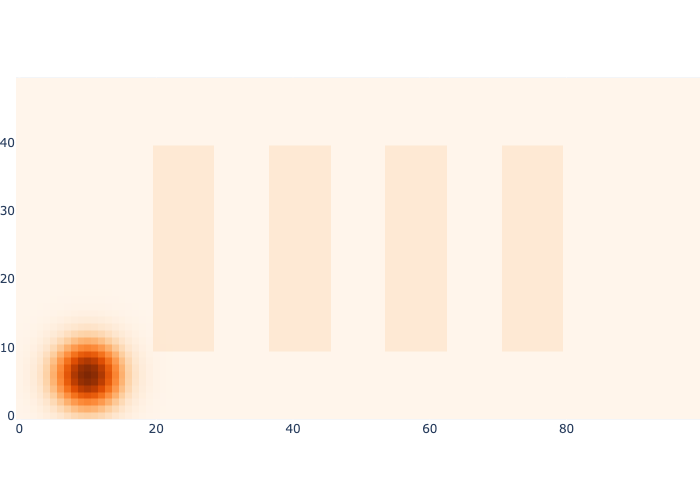

In [6]:
prior_mean = values.at(x[1])
prior_cov = np.diag([25,25])
prior = logistics.gaussian(logistics.map_coords, prior_mean, prior_cov)
logistics.show_map(prior/np.max(prior)+0.1*logistics.base_map)

The hardest and most computationally demanding part in the Markov localization algorithm to implement is the prediction step. Recall the formula:

$$
P(X_{k}|\mathcal{Z}^{k-1},\mathcal{U}^{k})=\sum_{x_{k-1}}P(X_{k}|x_{k-1},u_{k-1})P(x_{t-1}|\mathcal{Z}^{k-1},\mathcal{U}^{k-1}).
$$

Hence, for every cell in the predictive density approximation, we need to sum over *all* cells in the previous image. Not only that, but for every one of these $5000^2$, i.e., *25 million* cell combinations $(X_k,x_{k-1})$ we need to evaluate the Gaussian motion model $P(X_{k}|x_{k-1},u_{k-1})$. With python for-loops, this will be rather expensive, so in the code below build in two speedups:
1. We make the outer loop over the previous image, and threshold on the density;
2. we make use of the fact that the `logistics.gaussian` function is vectorized, i.e., we can process an entire row of the predictive image at a time.

The fast code looks like this:

In [7]:
def prediction_step(previous, control, motion_model_sigma):
    """Calculate predictive density given control and control stddev."""
    cov = np.eye(2) * motion_model_sigma**2
    predictive_density = np.zeros((50,100))
    for i in range(50):
        for j in range(100):
            # Speedup 1: threshold on previous[i,j]
            if previous[i,j]>1e-5:
                previous_xy = logistics.map_coords[i,j]
                mean = previous_xy + control
                for k in range(50):
                    # Speedup 1: vectorize Gaussian evaluation over predictive row:
                    motion_model = logistics.gaussian(logistics.map_coords[k], mean, cov)
                    predictive_density[k] += motion_model * previous[i,j]
    return predictive_density/np.sum(predictive_density)

If we have *no* measurements at all, but have a perfect measurement model, our "control tape" just pushes the Gaussian density along:

In [8]:
%%time
motion_model_sigma = 2
current_density = prior
for k in indices[:-1]:
    # prediction phase
    control = values.at(x[k+1]) - values.at(x[k]) # ground truth control
    current_density = prediction_step(current_density, control, motion_model_sigma)
# logistics.show_map(current_density/np.max(current_density) + 0.1*logistics.base_map)

CPU times: user 18.1 s, sys: 1.64 s, total: 19.7 s
Wall time: 12.4 s


<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures4/predictive.gif?raw=1" id="fig:predictive" style="width:14cm" alt="">
<figcaption>Evolution of the predictive density (no measurements).</figcaption>
</figure>

The figure above shows the result of purely predictive reasoning using a finite element discretization. As you can see, the density grows without bounds, and also goes *inside* the shelves. Without any measurements, we really do not know any better. 

The measurement update step takes the predictive density $P(X_{k}|\mathcal{Z}^{k-1},\mathcal{U}^{k})$ and *upgrades* it to the posterior density:

$$
P(X_{k}|\mathcal{Z}^{k},\mathcal{U}^{k}) \propto L(X_{k};z_{k})P(X_{k}|\mathcal{Z}^{k-1},\mathcal{U}^{k}).
$$

Note that this is so much simpler! We just have to code a pointwise multiplication and we are done. Because the ground truth trajectory never comes near and of the shelves, the proximity sensor is always `OFF`, and hence we multiply the predictive density with the corresponding `proximity_map_off` likelihood image:

In [9]:
%%time
predictive_density = prior
posterior_density = predictive_density * logistics.proximity_map_off
posterior_density /= np.sum(posterior_density)
for k in indices[:-1]:
    # prediction phase
    control = values.at(x[k+1]) - values.at(x[k]) # ground truth control
    predictive_density = prediction_step(posterior_density, control, motion_model_sigma)
    # measurement update phase
    posterior_density = predictive_density * logistics.proximity_map_off
    posterior_density /= np.sum(posterior_density)
# logistics.show_map(posterior_density/np.max(posterior_density) + 0.1*logistics.base_map)

CPU times: user 6.75 s, sys: 691 ms, total: 7.44 s
Wall time: 4.65 s


<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures4/posterior.gif?raw=1" id="fig:posterior" style="width:14cm" alt="">
<figcaption>Markov localization in action.</figcaption>
</figure>

The figure above shows Markov localization in action! The measurement information has *literally* squeezed the predictive density to a posterior that fuses predictive information with the knowledge that we cannot be anywhere near the shelves, or the wall. Note that the density is still spreading in the direction that the sensor does *not* yield information.


#### Exercises
- In principle our motion model should have told us that we cannot move inside shelves. How would you change the prediction code to make this so?
- The full Markov localization algorithm takes *less* time than the code *without* the measurement update. We do more work yet have faster inference. Why?

## Monte Carlo Localization

> Localization with a particle-filter is known as Monte Carlo Localization.

Samples are cheaper, faster, and better. The above finite element discretization of space is very costly, and most of the memory and computation is used to compute near-zero probabilities. 
While there *are* ways to deal with this, switching to a sampling-based representation gets us more bang for the buck, computation-wise. And, as we will see, it also leads to a very simple algorithm.
The sampling-based implementation of a Bayes filter is known as a **particle filter**.
Below we discuss it in a 2D context, but it is in fact rather general. 
When used for robot localization, this technique is known as ["Monte Carlo Localization" or MCL](https://www.ri.cmu.edu/publications/monte-carlo-localization-for-mobile-robots/).

A particle filter approximates the Bayes filter by (1) replacing an explicit probability mass function over finite elements with a set of samples, and (b) approximating the prediction step in the Bayes filter with a Monte Carlo approximation. We recursively assume to have access to a sampling based approximation of the filtering density over the previous state $x_{k-1}$, as a set of $S$ *weighted* samples:

$$
p(x_{t-1}|\mathcal{Z}^{k-1},\mathcal{U}^{k-1}) \approx \{x_{k-1}^{(s)}, w_{k-1}^{(s)}\}.
$$

We then implemented proceed in two phases:

1.  In the prediction phase we approximate the predictive distribution
    $p(x_{k}|\mathcal{Z}^{k-1},\mathcal{U}^{k})$ by drawing $S$ *unweighted* samples from the following **mixture density** of motion model densities:
    $$
    \{ x_k^{(t)} \} \sim \sum_s w_{k-1}^{(s)} P(x_{k}|x_{k-1}^{(s)},u_{k-1})P(x_{t-1}^{(s)}|\mathcal{Z}^{k-1},\mathcal{U}^{k-1}).
    $$

2.  In the measurement phase we upgrade this predictive density to a weighted sample approximation of the filtering distribution, by weighting each unweighted sample with the likelihood of $x_k^{(t)}$ given the measurement $z_{k}$:
    $$
    p(x_{t-1}|\mathcal{Z}^{k-1},\mathcal{U}^{k-1}) \approx \{x_k^{(t)}, L(x_k^{(t)};z_{k})\}.
    $$

We start off the algorithm with a set of $S$ samples from the prior, weighted by the likelihood on the first $x_1$ given the first measurement $z_1$:

$$
P(X_1|\mathcal{Z}^1=\{z_1\}, \mathcal{U}^1=\{\}) \approx \{x_1^{(t)}, L(x_1^{(t)};z_1)\}~\text{with}~x_1^{(t)}\sim p(x_1)
$$

In the "vanilla" particle filter outlined above, the number of samples stays constant over time, but variants exist that adapt the number of samples to the complexity of the density over time, or even to the available computation. Used in that way, a particle filter can be used as a "just in time" algorithm.

###  The Prediction Step
Again, the prediction phase is the most complex. A mixture density is simply a weighted sum of *component densities*, in this case a set of motion models. The weights are a probability mass function over the component indices and hence should sum to 1. Sampling from a mixture density proceeds in two steps:
1. Pick a component according to the weight distribution;
2 sample from the component.

As a toy example, let us assume a *Gaussian mixture density* with just two Gaussian components, respectively with weights 0.9 and 0.1:

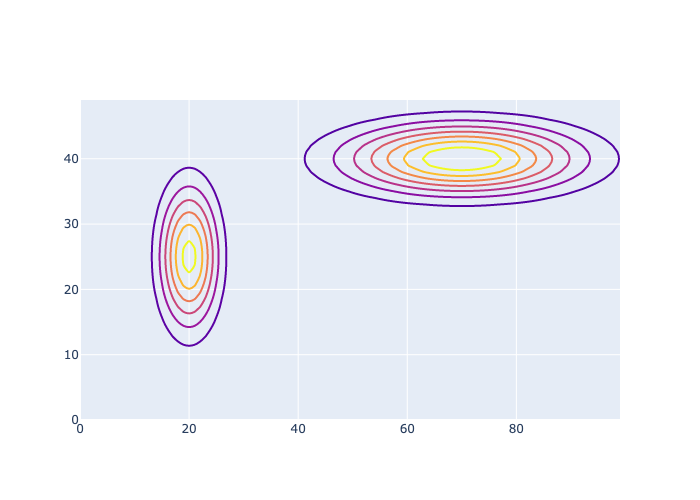

In [10]:
means = [gtsam.Point2(x,y) for x,y in [(20,25),(70,40)]]
covariances = [np.diag([sx**2,sy**2]) for sx,sy in [(5,10),(20,5)]]
data = [go.Contour(z=logistics.gaussian(logistics.map_coords, mean, cov), contours_coloring='lines', 
        line_width=2, showscale=False) for mean,cov in zip(means,covariances)]
fig = go.Figure(data=data); fig.show()

The following code samples 100 samples, rather inefficiently:

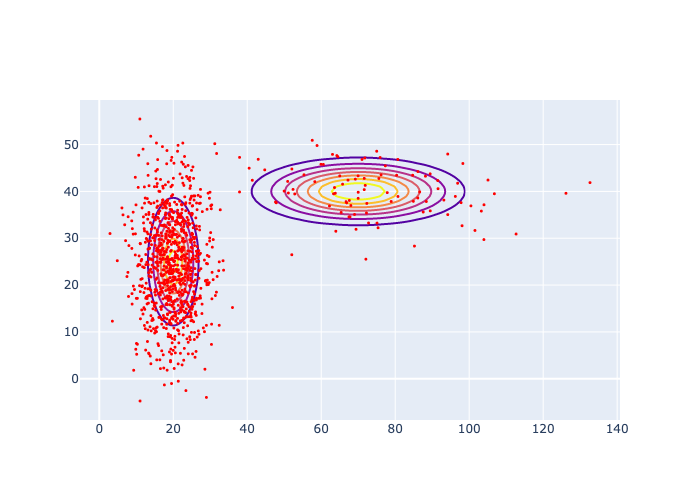

In [11]:
component_indices = rng.choice(2, size=1000, p=[0.9,0.1])
samples = np.array([rng.multivariate_normal(means[s], covariances[s]) for s in component_indices])
fig.add_trace(go.Scatter(x=samples[:,0],y=samples[:,1], mode="markers", 
        marker=dict(size=3, color="red")))

As you can see the first component is chosen much more often, which is exactly what we expected.

Armed with this general knowledge about sampling mixtures, we apply it below to code up the MCL prediction step:

In [12]:
def predict_samples(samples, weights, control, motion_model_sigma, size=500):
    """Create predictive density from weighted samples given control and control stddev."""
    weights /= np.sum(weights)
    component_indices = rng.choice(len(samples), size=size, p=weights)
    means = samples + control
    cov = np.eye(2) * motion_model_sigma**2
    return np.array([rng.multivariate_normal(means[s], cov) for s in component_indices])

### Evaluating the Likelihood

As before, we know that the ground truth trajectory stays away from obstacles at all times. However, we only have access to a likelihood *image*, not a function that evaluates the likelihood for an arbitrary coordinate. The following function calculates the correct cell for looking up the likelihood, and returns 0 likelihood if out of bounds:

In [13]:
def likelihood_off(xy):
    """Calculate likelihood by looking up value in proximity_map_off."""
    j, i = np.round(xy).astype(int)
    if i<0 or i>49 or j<0 or j>99: return 0.0
    return float(logistics.proximity_map_off[i,j])

### MCL Warehouse Example

Now that we know how to do the prediction step and evaluate the likelihood function, we are able to implement the entire Monte Carlo localization method. First, let us obtain 500 samples from the posterior:

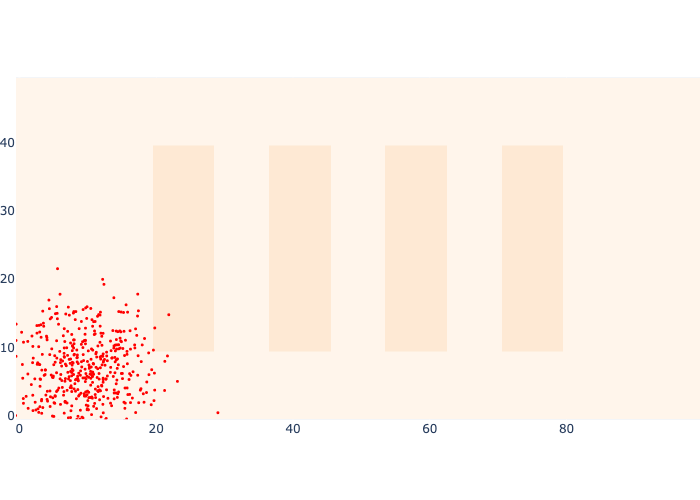

In [14]:
S=500
prior_samples = rng.multivariate_normal(prior_mean, prior_cov, size=S)
logistics.show_map(0.1*logistics.base_map, markers=prior_samples,
         marker=dict(size=3,color="red"))

Compare this sampling-based representation with the Markov localization representation of the prior above, and note they represent the *same* density, but using vastly different representations. In fact, they also use vastly different resources: for Markov localization we used 5000 cells, and here we use 500 two-dimensional vectors. In higher-dimensional state spaces this difference is even greater: what would happen if we wanted to represent orientation as well?

However, as discussed, we start off MCL with a set of *weighted* samples $\{x_1^{(t)}, L(x_1^{(t)};z_1)\}$, which represents the posterior for $k=1$. We do this by weighting each sample from the prior with the likelihood:

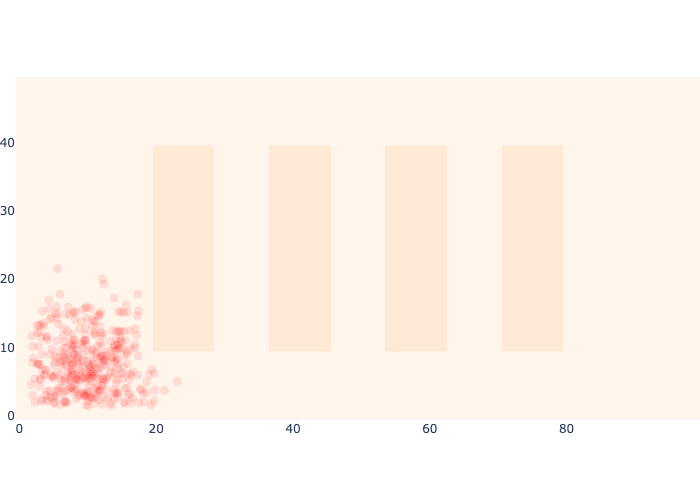

In [15]:
samples = prior_samples
weights = np.apply_along_axis(likelihood_off, 1, samples)
logistics.show_map(0.1*logistics.base_map, markers=samples,
         marker=dict(color="red", opacity=0.1, size=10*weights/np.max(weights)))

Note that all samples close to the wall and/or the shelves have disappeared, as they have zero weight. All remaining samples have the same weight.

In [16]:
%%time
for k in indices[:-1]:
    # prediction phase
    control = values.at(x[k+1]) - values.at(x[k])  # ground truth control
    samples = predict_samples(samples, weights, control, motion_model_sigma)
    # measurement update phase
    weights = np.apply_along_axis(likelihood_off, 1, samples)
# logistics.show_map(0.1*logistics.base_map, markers=samples,
#          marker=dict(color="red", opacity=0.1, size=10*weights/np.max(weights)))

CPU times: user 185 ms, sys: 2.76 ms, total: 188 ms
Wall time: 188 ms


<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures4/samples.gif?raw=1" id="fig:samples" style="width:14cm" alt="">
<figcaption>Monte Carlo localization in action.</figcaption>
</figure>

The figure above shows Monte Carlo localization in action! Comparing with Markov localization, we see that the results are consistent. Not only that, but if you look at the timing numbers, MCL runs at least an order of magnitude faster.


You might wonder about the samples that made it into the seemingly *wrong* aisles between the shelves. However, if we crank up the Markov localization visualization by a factor of 10, you will see that *in* fact the probability of being in those aisles is actually non-zero:

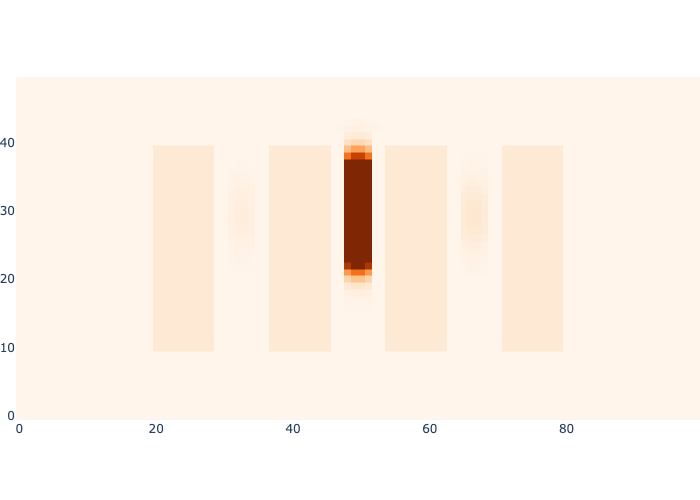

In [17]:
logistics.show_map(10*posterior_density/np.max(posterior_density) + 0.1*logistics.base_map)

MCL can be made to be *more* accurate than Markov localization, as in the limit an infinite number of samples will represent the actual densities exactly. Of course, we can also increase the resolution of the Markov localization representation, but at exponential cost. In contrast, the samples needed are proportional to the "volume" that the density occupies, an observation that underlies adaptive variants.

### Adding Range Sensing

Finally, and this is will be rather easy in MCL, let us investigate the effect of adding range sensing. This time we won't have the luxury to know the entire measurement sequence in advance, as we did with proximity. Rather, the likelihood will have to be given the output of the RFID sensor. Remember that was either a beacon ID and a range $(i,r)$, or $(\text{None},\infty)$.

In [18]:
def likelihood_range(xy, rfid_measurement):
    """Calculate likelihood of xy given range measurement."""
    _id, _range = rfid_measurement
    if _id is None:
        j, i = np.round(xy).astype(int)
        if i < 0 or i > 49 or j < 0 or j > 99:
            return 0.0
        return float(logistics.out_of_bound_map[i, j])
    else:
        sigma = 1.0  # In meters
        range_for_xy = logistics.rfid_range(xy, logistics.beacons[_id])
        return 0.0 if range_for_xy is None else np.exp(-1/(2 * sigma**2) * (range_for_xy - _range)**2)

We can also use this to illustrate how to *globally* localize, without any prior information at all, except that we are *somewhere* in the warehouse. We can encode this knowledge as samples by uniformly sampling over the entire range for $x$ and $y$. Because our knowledge is now so diffuse, we use 2000 samples instead of 500 to better approximate it:

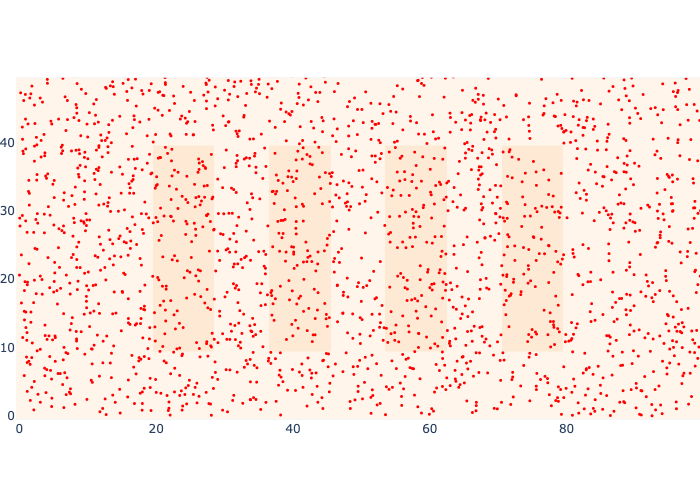

In [19]:
T=2000
prior_samples = rng.uniform(low=gtsam.Point2(0,0), high=gtsam.Point2(100,50), size=(T,2))
logistics.show_map(0.1*logistics.base_map, markers=prior_samples,
         marker=dict(size=3,color="red"))

The first range measurement happens to be out if range, and we can see the effect on our estimate for the posterior $p(x_1|z_1)$ quite clearly:

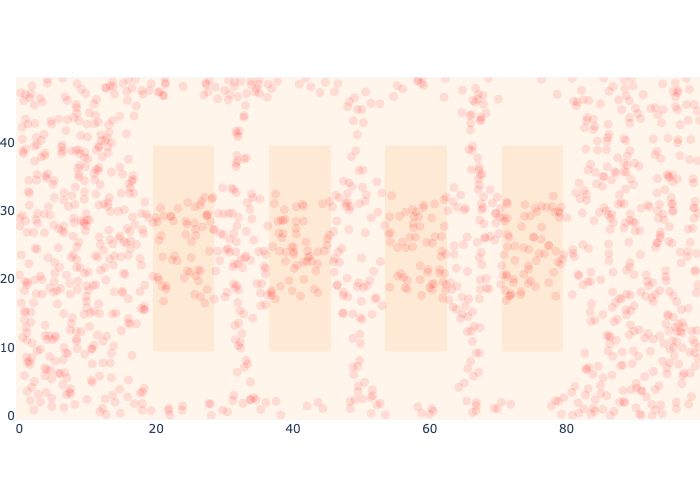

In [20]:
samples = prior_samples
range_measurement = logistics.rfid_measurement(values.at(x[1]))
weights = np.apply_along_axis(likelihood_range, 1, samples, range_measurement)
logistics.show_map(0.1*logistics.base_map, markers=samples,
         marker=dict(color="red", opacity=0.1, size=10*weights/np.max(weights)))

As expected, the likelihood has "punched holes" around the beacons, because we *know* we cannot have been near them. This is the power of *negative* information. When we combine it with the proximity OFF measurement, we narrow our posterior down even more:

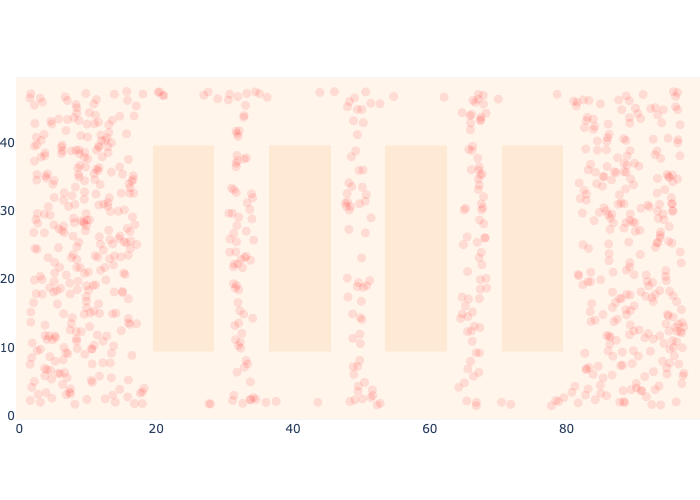

In [21]:
weights *= np.apply_along_axis(likelihood_off, 1, samples)
logistics.show_map(0.1*logistics.base_map, markers=samples,
         marker=dict(color="red", opacity=0.1, size=10*weights/np.max(weights)))

We are now ready to bring it all together, now multiplying *two* likelihoods in ever measurement update phase:

In [22]:
%%time
for k in indices[:-1]:
    # prediction phase
    control = values.at(x[k+1]) - values.at(x[k])  # ground truth control
    samples = predict_samples(samples, weights, control, motion_model_sigma)
    # measurement update phase
    range_measurement = logistics.rfid_measurement(values.at(x[k]))
    weights = np.apply_along_axis(
        likelihood_range, 1, samples, range_measurement)
    weights *= np.apply_along_axis(likelihood_off, 1, samples)
# logistics.show_map(0.1*logistics.base_map, markers=samples,
#          marker=dict(color="red", opacity=0.1, size=10*weights/np.max(weights)))

CPU times: user 204 ms, sys: 2.93 ms, total: 207 ms
Wall time: 208 ms


<figure>
<img src="https://github.com/gtbook/robotics/blob/main/Figures4/global.gif?raw=1" id="fig:global" style="width:14cm" alt="">
<figcaption>Global localization using MCL aided by range sensing.</figcaption>
</figure>

The figure above shows global localization in action! At the onset, we are very confused as to where we might be in the warehouse, but we still have *some* knowledge. Then we move within range of beacon $0$, which immediately localizes us: it acts a bit like a GPS sensor, especially in combination with what we sensed before. After that the particular shape of the range likelihoods makes for some interesting antics, and at the end we are quite a bit more certain that we are in the center aisle. 

This example showed off *two* really nice properties of Monte Carlo localization (and, for that matter, Markov localization):
1. We can reason about multi-modela densities and even the complete absence of knowledge.
2. We can incorporate powerful, *negative* information, such as out of range measurements.

To emphasize the latter point even more, note that for the last few time steps in the animation above we are *out* of beacon range, and you can see a bit of "squeezing" of the sample cloud at the very top, because of this. Negative information for the win!

## Kalman Smoothing and Filtering

> Where Gaussians are used, Kalman was there first.

The final and mathematically most challenging approach we will discuss is Kalman smoothing and filtering. Ironically, while the math is harder, the circumstances in which these methods can be applied are more limited.
The math is only exact for (a) linear measurement models and (b) Gaussian additive noise. 
In addition, although there are ways to deal with nonlinear sensors, a more serious limitation is that the density on the state can only ever be Gaussian itself.

These methods are incredibly important in robotics, however, For all their limitations, Kalman smoothers and filters are incredibly efficient, and are at the core of the navigation stack of many systems, robots and otherwise. In fact, the Kalman filter was developed in order to perform navigation on board of military aircraft in the sixties, and were able to run on the extremely limited computational hardware - by today's standards - on board those aircraft.


### Factor Graphs and Least Squares

> When given measurements and actions, we create a factor graph directly.

**Kalman smoothing** is the equivalent of the Viterbi algorithm for hidden Markov model, but for continuous state spaces. 

In the continuous case, we build the factors directly from given controls and measurements. A factor graph now encodes the negative log-posterior 

$$\Phi(X)=\sum_i \phi(X_i) = \frac{1}{2} \sum_i \|A_i X_i-b_i\|^2.$$

In the continuous case we use *minimization* of the log-likelihood rather than maximization over the probabilities. The main reason is because then inference becomes a linear least squares problem.

A least-squares problem is convex and can be solved in closed form. The linear terms within the square norm above are *sparse*, in the sense that $X_i$ is only a *subset* of the continuous variables $X$. For example, a simple sensor fusion problem on two scalar variables $x_1$ and $x_2$ would be one where both have a simple prior on them, resp. with $\mu_1=3$ and $\mu_2=7$, and we know that the difference between them is equal to $5$. This yields three factors that have to be minimized over $x_1$ and $x_2$:

$$
\Phi(X)= \frac{1}{2} \|x_1-3\|^2 + \frac{1}{2} \|(x_2-x_1)-5\|^2 + \frac{1}{2} \|x_2-7\|^2.
$$

This corresponds to the following 

|$X_i$|$A_i$|$b_i$|
|-|-|-|
|$x_1$|[1]|3|
|$x_1, x_2$|[-1 1]|5|
|$x_2$|[1]|7|

We can collect all three matrices $A_1$, $A_2$, and $A_3$ into one sparse matrix $A$ and corresponding right-hand-side $b$:

$$A=\begin{pmatrix} 1 & 0 \\ -1 & 1 \\ 0 & 1 \end{pmatrix}~~\text{and}~~B=\begin{pmatrix} 3 \\ 5 \\ 7 \end{pmatrix}.$$

You can convince yourself that the minimization problem can then be written as

$$X^* = \arg \min_X \Phi(X) = \arg \min_X \frac{1}{2} \|A X-b\|^2$$

which is now a *sparse* linear least-squares problem.

Setting the derivative to zero and solving for $X^*$ we obtain:

$$\begin{align*}
A^T(A X^* - b) &= 0 \\
(A^T A) X^* &= A^T b \\
X^* &= (A^T A)^{-1} A^T b 
\end{align*}$$

This is known as a **system of normal equations**, and the last equation above is a closed from solution for it. 

Solving a linear least-squares problem this way can be expensive. The matrix $A$ can be very high dimensional, but luckily in many sensor fusion scenarios it is exceedingly *sparse*. Still, we have to proceed with some care, as in general the matrix $(A^T A)^{-1}$ is *not* sparse. The matrix $Q \doteq A^T A$ is known as the **Hessian** or **Information Matrix** and has dimensions $n\times n$ if there are $n$ scalar unknowns. In general, it takes $O(n^3)$ work to compute it, which is only 27 for $n=3$, but is already 1 *billion* for $n=1000$.

### Numerical Example
It is trivial to implement in numpy for the small example above:

In [23]:
A,b = np.array([[1.,0.],[-1.,1.],[0.,1.]]), np.array([3.,5.,7.])
X_optimal = np.linalg.inv(A.T @ A) @ A.T @ b
print(X_optimal)

[2.66666667 7.33333333]


Note that in this simple sensor fusion example, a compromise solution is obtained: all factors are equally *unhappy*. We can compute the error vector as $A X^* - b$ and find that the errors is equally divided between all factors:

In [24]:
print(A @ X_optimal - b)

[-0.33333333 -0.33333333  0.33333333]


#### Exercise

What would make the errors *not* divide equally between factors?

### Sparse Least-Squares

In practice we use *sparse factorization methods* to solve for $X^*$. In particular, *sparse Cholesky* factorization can efficiently decompose the sparse Hessian $Q$ into its matrix square root $R$

$$A^T A=R^T R$$

where $R$ is *upper-triangular* and sparse as well. There is one wrinkle: the sparsity of $R$ depends (dramatically) on the column ordering chosen for $A$, and the optimal ordering is hard to find (NP-complete, in fact). Hence, many heuristic ordering methods exist that are applied in practice.

After we found $R$, which is where the heavy lifting occurs, we can efficiently solve for $X^*$ in two steps. First, we solve for an auxiliary vector $y$:

$$\begin{align*}
(R^T R) X^* &= A^T b \\
R^T (R X^*) &= A^T b \\
R^T y &= A^T b
\end{align*}$$

In the last line, $R^T$ is lower-triangular, and hence $y$ can be easily solved for proceeding from $y_1$ to $y_n$, via *forward-substitution*. We then turn around use the computed value of $y$ to solve for $X^*$ by *back-substitution*:

$$R X^*=y.$$

Both these steps are $O(n^2)$ for dense matrices, but typically closer to $O(n)$ for sparse matrices.

There is a deep connection between sparse factorization methods and the sum-product algorithm discussed in the previous chapter. In fact, sparse factorization *is* sum-product, where one continuous variable is eliminated at a time. The factor graph corresponding to a sparse least squares problem correspond to its sparsity pattern. In this graphical framework, the *product* is implemented by collecting all factors connected to that variable, and the *sum* is implemented by expressing the variable to be eliminated as a linear combination of its neighbors in the graph.

### Example with GPS-Like Measurements

> We build a factor graph and then simply call optimize.

GTSAM is built around state of the art sparse factorization methods, and hence can very efficiently solve large sensor fusion problems, like the localization problem with GPS-like measurements.
Below we illustrate this with an example in code for the GPS-like measurements, which is easily tackled using optimization. Range measurements can also be handled, but *out of range* measurements are not so easy, so we will defer handling range to the next section.

We simulate measurements using the ground truth trajectory but with noise added, by creating a quick Bayes net do this for us. Remember from the previous section that the measurements are in centimeters, so the number $30$ below is the standard deviation of the measurement noise, in centimeters:

In [25]:
C = 100 * np.eye(2)
measurement_model_sigma = 30
z = {k: gtsam.symbol('z', k) for k in indices}
bn = gtsam.GaussianBayesNet()
for k in indices:
    conditional_on_zk = gtsam.GaussianConditional.FromMeanAndStddev(
        z[k], C, x[k], [0, 0], measurement_model_sigma)
    bn.push_back(conditional_on_zk)
simulation = bn.sample(values)
print(f"measurement on {values.at(x[1])} = {simulation.at(z[1])}")


measurement on [10.  6.] = [980.21898282 565.87931563]


Notice how the measurement is scaled by 100, and is corrupted by noise. Now we are finally ready to create a GaussianFactorGraph that will fuse the information from the prior, the measurements, and the motion models:

In [26]:
gfg = gtsam.GaussianFactorGraph()

# The prior
p_x1 = gtsam.GaussianDensity.FromMeanAndStddev(x[1], values.at(x[1]), 0.5)
gfg.push_back(p_x1)

# Create motion model factors from ground truth trajectory displacements
for k in indices[:-1]:
    state = values.at(x[k])
    next_state = values.at(x[k+1])
    displacement = next_state - state
    # |next_state - (A*state + B*u)|
    gfg.push_back(gtsam.GaussianConditional.FromMeanAndStddev(
        x[k+1], np.eye(2), x[k], displacement, motion_model_sigma))

# Convert the conditionals in Bayes net from above into likelihood factors
for k in indices:
    conditional_on_zk = bn.at(k-1)
    measurement = simulation.at(z[k])
    likelihood_on_xk = conditional_on_zk.likelihood(measurement)
    gfg.push_back(likelihood_on_xk)

Below we show the factor graph, which looks exactly like the one for inference in an HMM, except we now have more states, and they are continuous. The two problems have essentially the same computational *structure*:

In [27]:
position_hints = {'x': 1}
pos = {0:(0.35,1)}
pos.update({k:(k+0.5,1) for k in indices[:-1]}) # binary
pos.update({k+N-1:(k,0.5) for k in indices}) # unary
show(gfg, hints=position_hints, factor_positions=pos)

Now we can find the optimal solution, using the `optimize` method. In the Gaussian factor graph case, this solves a linear least-squares problem with a continuous variant of the sum-product algorithm:

In [28]:
least_squares_solution = gfg.optimize()

Below we compare the estimated trajectory with the ground truth trajectory:

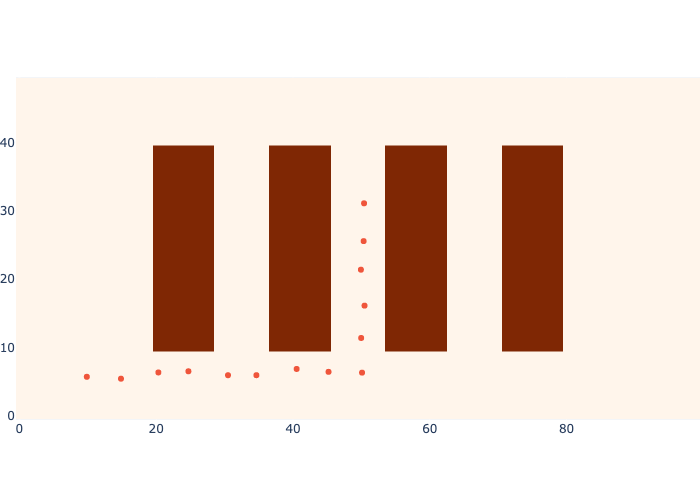

In [29]:
estimated = np.array([least_squares_solution.at(x[k]) for k in indices])
logistics.show_map(logistics.base_map, estimated)

## GTSAM 102

> A deeper dive in the GTSAM concepts used above.

Recall the `gtsam.GaussianFactorGraph` `gfg`:

In [30]:
show(gfg, hints=position_hints, factor_positions=pos)

We can also visualize the sparse $A$ matrix, which is called the **sparse Jacobian** of the system:

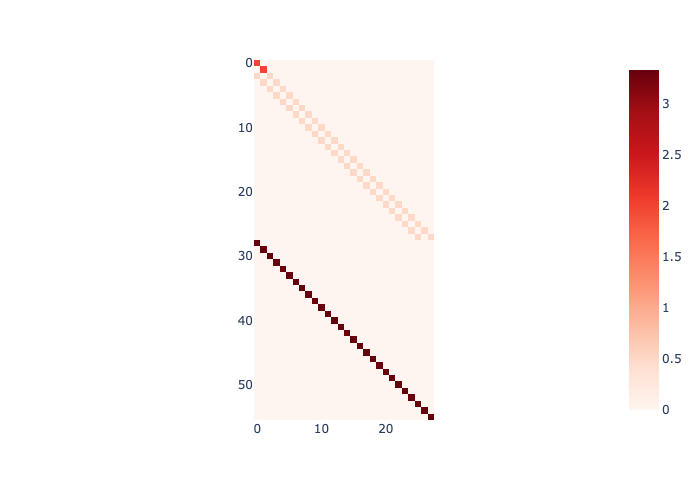

In [31]:
# show [A|b]
A, b = gfg.jacobian()
px.imshow(np.abs(A), color_continuous_scale='Reds')


In fact, the deep connection between factor graphs and sparse linear algebra is this:
> Columns correspond to variables, and rows correspond to factors

You can make out, from the top:
- the first two rows correspond to the prior
- the two darker diagonals correspond to the motion model factors
- the single red diagonal corresponds to the measurements



We can use the method `eliminateSequential` to use the linear-Gaussian sum-product algorithm (matrix factorization!) to turn it into a Bayes net, which encodes the multivariate Gaussian posterior:

In [32]:
gaussian_posterior = gfg.eliminateSequential()
show(gaussian_posterior, hints=position_hints)

This Bayes net *is* the upper-triangular (DAG!) Cholesky factor $R$ we discussed above:

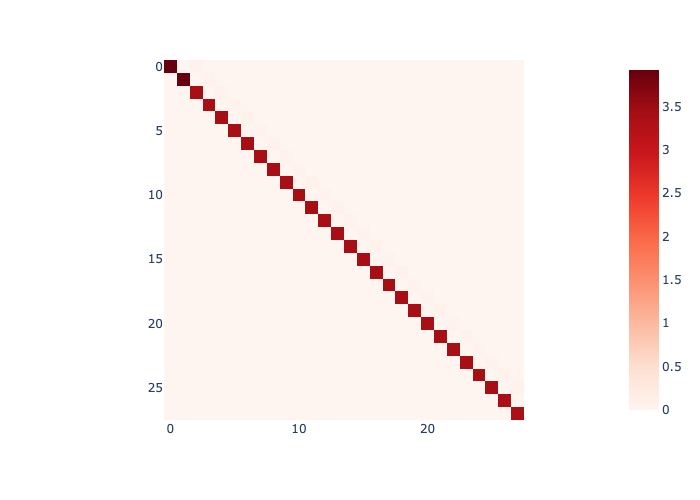

In [33]:
R, d = gaussian_posterior.matrix()
display(px.imshow(np.abs(R), color_continuous_scale='Reds'))

Indeed, here the correspondence is: 
> columns correspond to variables, and rows correspond to Gaussian conditionals.

In general, the correspondence is about *block* columns, as vraiables in this case are two-dimensional, and *block* rows. For example, the first `GaussianConditional` in the `gaussian_posterior` Bayes net corresponds to the first two rows above, and can be shown like so:

In [34]:
gaussian_posterior.at(0).print("First two rows are: ")

First two rows are:   Conditional density [x1] 
  R = [ 3.91933       0 ]
      [       0 3.91933 ]
  S[x2] = [ -0.0637865          0 ]
          [          0 -0.0637865 ]
  d = [ 37.6757 22.1659 ]
  No noise model
